In [1]:
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
	!pip install pmdarima
# Note pmdarima and pycaret libraries are incompatible for version 2021/12/24
# necessitates separate envs

# ARIMA Model
### statsmodels and pmdarima libraries
1. Sanity Check
2. Investigation of 2-years of data
3. Running ARIMA method of anomaly detection

In [2]:
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from data.jpx import *
from utils.outlier import *
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

## 1. Sanity Check for ARIMA Model

Simple Outliers are injected at point 100 and point 200 of 300 random numbers between 0 and 1. Red lines represent where outliers were detected. Dotted green lines are where outliers were specifically injected.

1. ✅✅  Global Outlier -- The two injected global outliers were both detected. 
2. ✅✅  Conditional Outlier -- The two injected conditional outliers were both detected. 
3. ✅✅ Collective Outlier -- The two introduced collective outliers were  detected. 

All injected outliers, as well as number of outliers that were not injected, are detected

In [17]:
def test_stationarity(ts_data, column='', signif=0.05, series=False):
	if not isinstance(ts_data, pd.Series):
		adf_test = adfuller(ts_data, autolag='AIC')
	else:
		adf_test = adfuller(ts_data['value'], autolag='AIC')
	p_value = adf_test[1]
	if p_value <= signif:
		test_result = "Stationary"
	else:
		test_result = "Non-Stationary"
	return test_result

def arima_outliers(df, alpha=0.02, graph=None):
	X = None
	if len(df.columns) > 1:
		X = df.drop(columns=df.columns[0], axis=1)
		X['const']=1

	model = pm.auto_arima(df.iloc[:,0],X=X, start_p=1, start_q=1,
			test='adf',       # use adftest to find optimal 'd'
			max_p=3, max_q=3, # maximum p and q
			m=1,              # frequency of series
			d=None,           # let model determine 'd'
			seasonal=False,   # No Seasonality
			start_P=0, 
			D=0, 
			trace=True,
			error_action='ignore',  
			suppress_warnings=True, 
			stepwise=True)

	res = model.arima_res_
	predict = res.get_prediction()
	predict_ci = pd.DataFrame(columns=["lower y", "upper y"],  data=predict.conf_int(alpha = alpha))
	results = []
	# print(len(df), len(predict_ci))
	i = 0
	for x in df.iloc[:, 0].items():
		#print(f"i: {i}   x: {x}  type(x): {type(x)}")
		if x[1] < predict_ci.iloc[i]["lower y"] or x[1] > predict_ci.iloc[i]["upper y"]:
			results.append(True)
		else:
			results.append(False)
		i = i+1
	predict_dy = res.get_prediction(dynamic=75)
	predict_dy_ci = pd.DataFrame(columns=["lower y", "upper y"],  data=predict_dy.conf_int())

	if graph != None:
	# Graph
		fig, ax = plt.subplots(figsize=(18,4))
		npre = 4
		ax.set(title='Time Series', xlabel='Time', ylabel='Y lablel')
		# Plot data points
		if 'const' in df.columns:
			df.drop(['const'], axis=1).iloc[:].plot(ax=ax,  label='Observed')
		else:
			df.iloc[:].plot(ax=ax,  label='Observed')
		# # Plot predictions
		ax.plot(predict.predicted_mean[:], ls='--', c='g', label='One-step-ahead forecast')
		ci = predict_ci
		ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)
		for i, x in enumerate(results):
			if x:
				# plt.axvline(x=i, label='line at x = {}'.format(X[i]), c='r')
				plt.axvline(x=i, c='r')
		for g in graph:
			plt.axvline(x=g, ls=':', c='g')
		legend = ax.legend(loc='lower right')
	return results


μ: -0.12878672074078068   σ: 1.3262905695169493    MAD: 0.9401193829979418   first: 100
Stationary
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=925.495, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1046.671, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=925.711, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=962.485, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=926.976, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=927.035, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=939.347, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=925.783, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=928.893, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=926.895, Time=0.07 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.488 seconds
Found 4 outliers


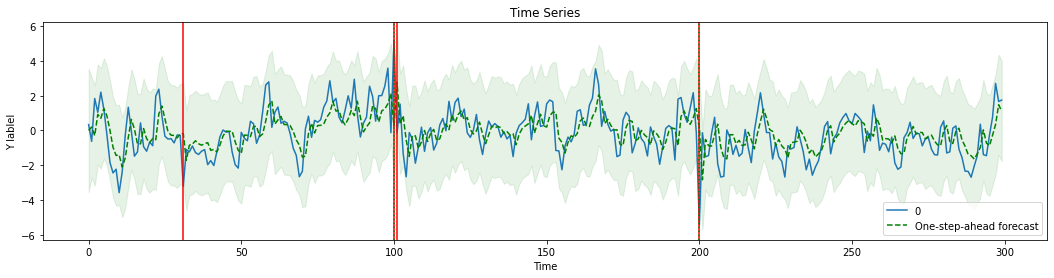

In [18]:
# Global Outlier 
correl_series = injectPoint(arma_1_1_sample(), second=200) #[:99]
print(test_stationarity(correl_series))
correl_df = pd.DataFrame(correl_series)
results = arima_outliers(correl_df, alpha=0.01, graph=[100,200])
print(f"Found {sum(results)} outliers")

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-553.475, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-557.218, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-555.403, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-555.399, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.549 seconds


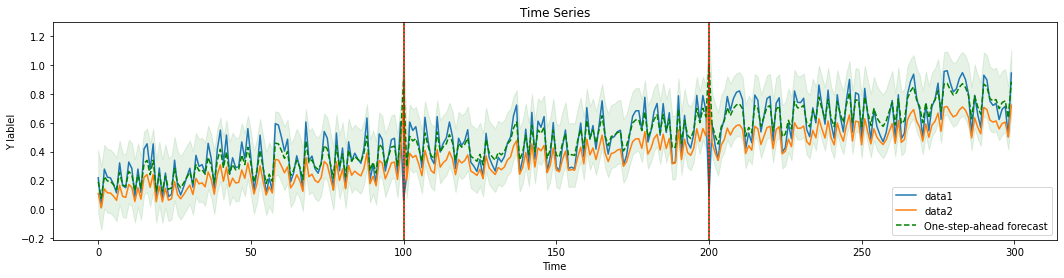

In [19]:


# Conditional Outlier
# Warning multivariate time series can be tricky
# See https://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels/
data1 = [x/2 + i/600 for i,x  in enumerate(test_0to1(2))]
data2 = [x/4 + i/600 for i,x  in enumerate(test_0to1(2))]
data1, data2 = injectConditional(data1,data2, second=200)
df_2 = pd.DataFrame(list(zip(data1, data2)), columns =['data1', 'data2'])
# print(f"df_2:\r\n{df_2.head()}")
results = arima_outliers(df_2, alpha=0.02, graph=[100,200])

μ: 0.4900447644798076   σ: 0.281168482593704  first: 100
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-366.617, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=91.364, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-349.574, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-158.068, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-369.282, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-371.073, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-369.456, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-369.428, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 1.277 seconds


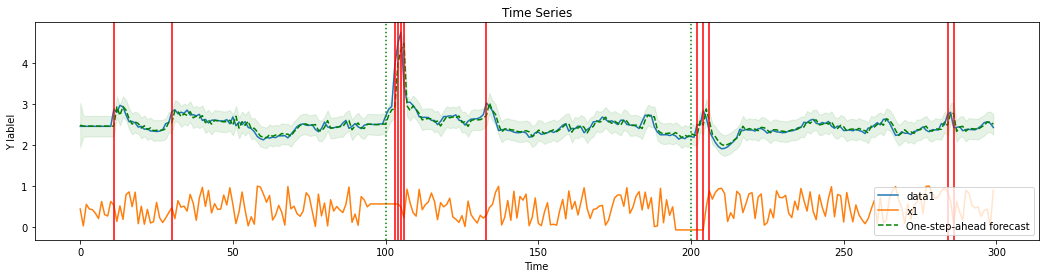

In [20]:

# Collective Outlier
points = injectCollective(test_0to1(2), second=200)
correl_df = pd.DataFrame({'data1': points}, index=list(range(0, len(points))))
correl_df["x1"] = correl_df['data1']
correl_df["data1"]  = correl_df['x1'].rolling(12).std(ddof=0)
correl_df["data1"] = correl_df["data1"].apply(lambda x: max(x,0.001))
correl_df["data1"] = correl_df["data1"].fillna(correl_df["data1"].mean())
correl_df['data1'] = np.log(3/correl_df['data1'])
results = arima_outliers(correl_df, alpha=0.05, graph=[100,200])


## 2. Investigation of 2-years of data

### Results with actual market data
### Sony Group Corp. (ソニーグループ株式会社)

In [5]:
TSE33 = TOPIX_SECTORS()
NKY = Nikkei225()
inst = NKY.get_ric("6758.T")
print(f"inst: {inst}")
s = Stock(inst, TSE33)
s.df_intraday.head()

inst: [132 '6758.T' 'Sony Group Corp' 'Electric Appliances']


,Date,HIGH,LOW,OPEN,CLOSE,COUNT,VOLUME,DATE,TIME,RETURN,RETURN_ADJ,CLOSE_TPX,RETURN_TPX,RETURN_ADJ_TPX,RETURN_NORM,RETURN_NORM_TPX
0,2020-11-24 00:06:00,9465.0,9430.0,9449.0,9440.0,234.0,114000.0,2020-11-24,00:06:00,-0.000635,-0.377085,3042.82,-0.001542,-3.681627,0.420024,0.266058
1,2020-11-24 00:07:00,9441.0,9402.0,9441.0,9402.0,211.0,78800.0,2020-11-24,00:07:00,-0.004025,-2.671680,3037.71,-0.001679,-4.216017,0.343129,0.261839
2,2020-11-24 00:08:00,9417.0,9400.0,9404.0,9409.0,187.0,62500.0,2020-11-24,00:08:00,0.000745,0.530153,3037.93,0.000072,0.201721,0.450426,0.296719
3,2020-11-24 00:09:00,9434.0,9408.0,9410.0,9429.0,141.0,42600.0,2020-11-24,00:09:00,0.002126,1.578632,3039.91,0.000652,1.949211,0.485562,0.310516
4,2020-11-24 00:10:00,9442.0,9423.0,9427.0,9436.0,137.0,62500.0,2020-11-24,00:10:00,0.000742,0.584672,3040.33,0.000138,0.417350,0.452253,0.298421


Order of differencing:  1 1 1


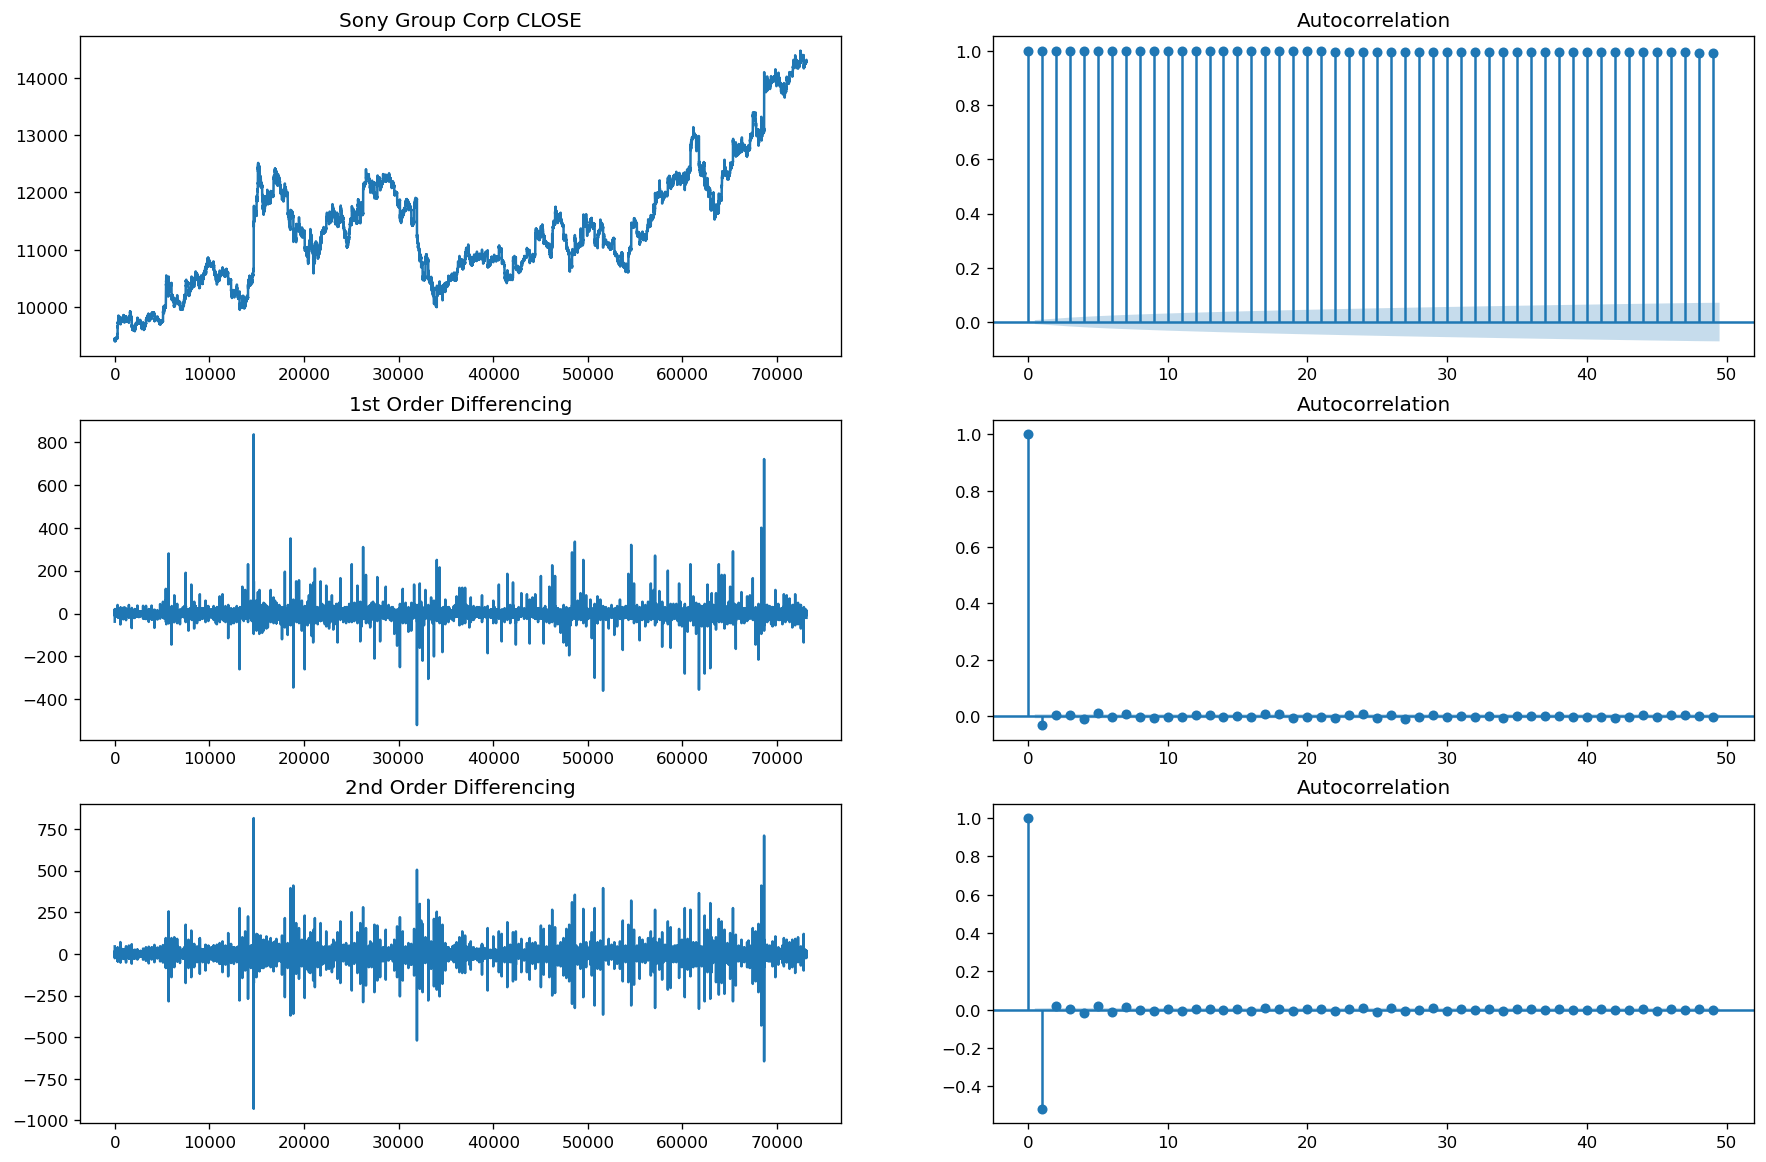

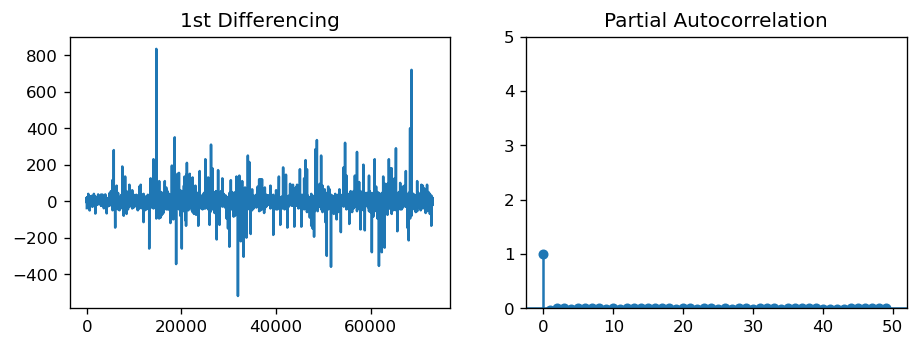

In [21]:

## Adf Test
df = s.df_intraday['CLOSE'].dropna()
print("Order of differencing: ", ndiffs(df, test='adf'), ndiffs(df, test='kpss'), ndiffs(df, test='pp'))

plt.rcParams.update({'figure.figsize':(18,12), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df); axes[0, 0].set_title(f"{inst[2]} CLOSE")
# axes[0,1].set_xlim([0, 100])
plot_acf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2)
axes[0].plot(df.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.diff().dropna(), ax=axes[1])

plt.show()

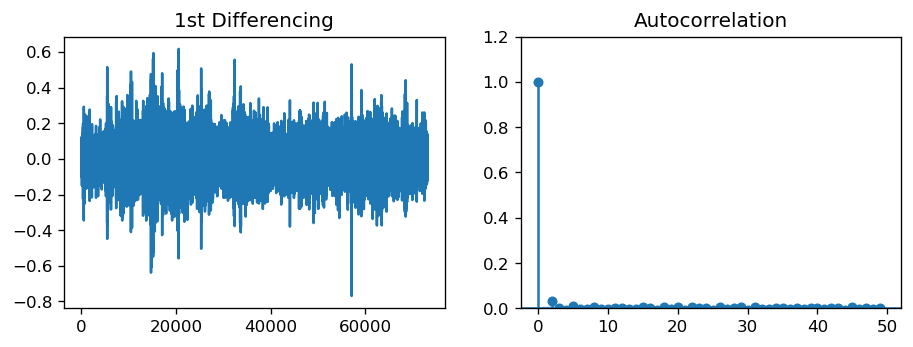

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-225536.818, Time=12.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-225057.568, Time=7.67 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-225542.783, Time=8.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-225553.751, Time=18.83 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=86033.675, Time=3.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-225556.886, Time=24.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-225553.724, Time=22.17 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-225559.772, Time=18.80 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-225556.505, Time=32.25 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-71808.877, Time=14.56 sec

Best model:  ARIMA(0,0,3)(0,0,0)[0] intercept
Total fit time: 161.906 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                73105
Model:               SARIM

In [23]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
series = s.df_intraday['RETURN_NORM']
fig, axes = plt.subplots(1, 2)
axes[0].plot(series.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(series.diff().dropna(), ax=axes[1])

plt.show()

model = pm.auto_arima(series, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

<class 'statsmodels.tsa.arima.model.ARIMAResultsWrapper'>
                               SARIMAX Results                                
Dep. Variable:            RETURN_NORM   No. Observations:                73105
Model:                 ARIMA(0, 0, 3)   Log Likelihood              112784.874
Date:                Fri, 31 Dec 2021   AIC                        -225559.749
Time:                        02:54:48   BIC                        -225513.750
Sample:                             0   HQIC                       -225545.590
                              - 73105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4327      0.000   2504.403      0.000       0.432       0.433
ma.L1         -0.0828      0.003    -29.169      0.000      -0.088      -

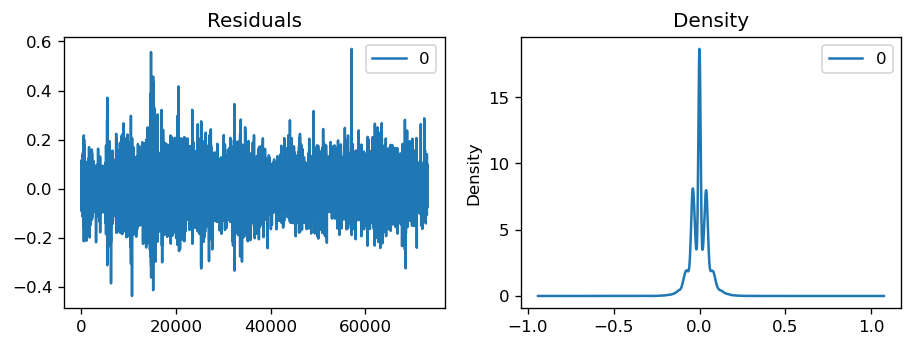

In [24]:
model = ARIMA(series, order=(0,0,3))
fit_res = model.fit()
print(type(fit_res))
print(fit_res.summary())

residuals = pd.DataFrame(fit_res.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


In [25]:
# In-sample one-step-ahead predictions
predict = fit_res.get_prediction()
predict_ci = predict.conf_int()
predict_dy = fit_res.get_prediction(dynamic=75)
predict_dy_ci = predict_dy.conf_int()

df_all = pd.DataFrame({'RETURNS': series, 'PREDICT': predict.predicted_mean, 'lower': predict_ci['lower RETURN_NORM'], 'upper': predict_ci['upper RETURN_NORM'] })
df_all.head()

,RETURNS,PREDICT,lower,upper
0,0.420024,0.432716,0.330975,0.534458
1,0.343129,0.433751,0.332348,0.535154
2,0.450426,0.440293,0.338900,0.541687
3,0.485562,0.432663,0.331274,0.534053
4,0.452253,0.428940,0.327551,0.530329


0    0.420024
1    0.343129
2    0.450426
3    0.485562
4    0.452253
Name: RETURN_NORM, dtype: float64


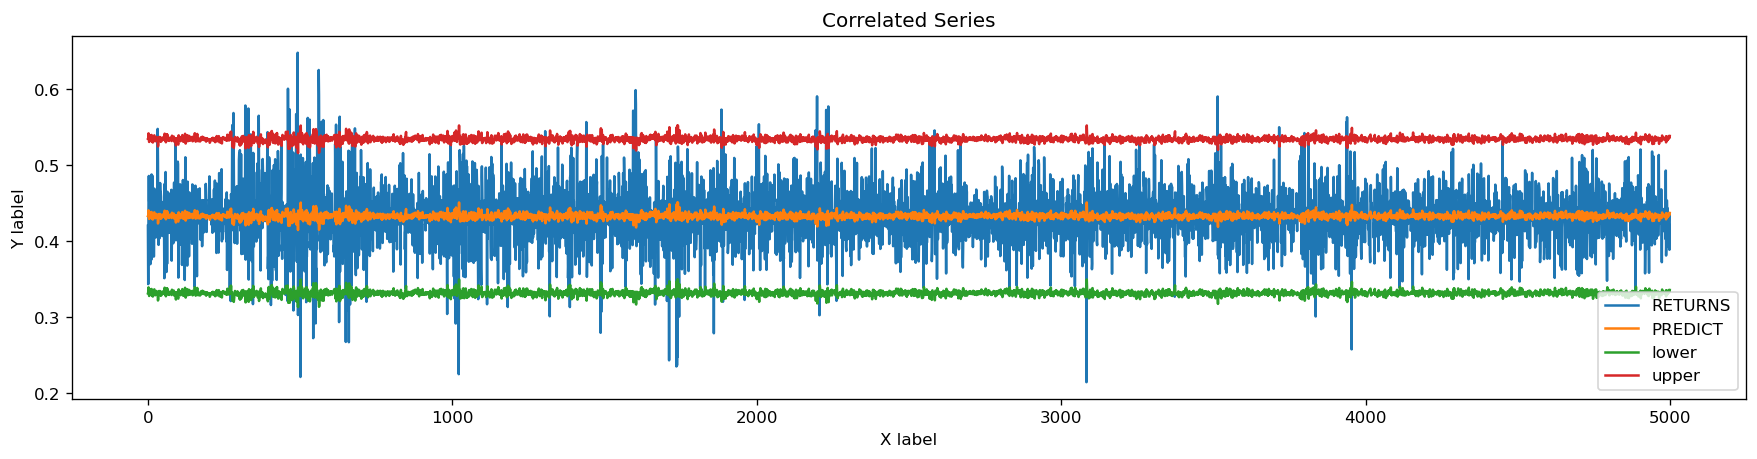

In [26]:
print(series[:5])

# Graph
fig, ax = plt.subplots(figsize=(18,4))
npre = 4
ax.set(title='Correlated Series', xlabel='X label', ylabel='Y lablel')
# Plot data points
# correl_df.iloc[75:, 0].plot(ax=ax, style='o', label='Observed')
df_all[0:5000].plot(ax=ax, label='Observed')
legend = ax.legend(loc='lower right')
# model.plot_diagnostics(figsize=(8,8))
# plt.show()

## 3. Running ARIMA method of anomaly detection

In [6]:

def arima_outliers_ranked(df):
	X = None
	if len(df.columns) > 1:
		# df['const']=1  # needed for autoarima
		X = df.drop(columns=df.columns[0], axis=1)
		# print(f"X: {X.head()}")

	# model = pm.auto_arima(df.iloc[:,0],X=X, start_p=1, start_q=1,
	# 		test='adf',       # use adftest to find optimal 'd'
	# 		max_p=3, max_q=3, # maximum p and q
	# 		m=1,              # frequency of series
	# 		d=None,           # let model determine 'd'
	# 		seasonal=False,   # No Seasonality
	# 		start_P=0, 
	# 		D=0, 
	# 		trace=True,
	# 		error_action='ignore',  
	# 		suppress_warnings=True, 
	# 		stepwise=True)


	model = ARIMA(order=(0,0,0), endog=df.iloc[:,0],exog=X)
	res = model.fit()

	# res = model.arima_res_
	predict = res.get_prediction(0,len(df)-1)
	df['predicted'] = predict.predicted_mean.copy()
	df['Anomaly_Score'] = (df[df.columns[0]] - df['predicted']).abs()
	df["rank"] = df["Anomaly_Score"].rank(method="first", ascending=False).astype(int)
	df.reset_index(inplace=True)
	return df 

In [93]:
%%capture --no-stdout
for stock in [1332]:   # [1332, 3103, 5707, 6703, 6098, 6758, 7203, 9432]: 
	inst = NKY.get_ric(f"{str(stock)}.T")
	# s = Stock(inst, TSE33)
	print(f"inst: {inst}")
	# Models starting with lowercase use PyCaret, Upper Case use PyOD library
	#                  ['abod', 'cluster', 'histogram', 'iforest', 'knn', 'lof', 'pca', 'svm', 'AutoEncoder (AE)', 'DeepSVDD (DeepSVDD)']:
	for model_name in  ['arima']:
		for outlier_type in ["All Three"]: # ["Global", "Contextual", "Collective", "All Three"]:
			for no_to_find in [2]:  #[0,1,2]  only used for 'All Three' 
				y_preds = []
				y_trues = []
				rankings = []
				sizes = []
				anomalies = []

				field, start, end = "RETURN_NORM", 0, len(s.unique_dates)
				for i in range(start, end):
					df = s.window(s.unique_dates[i], wdw_len=0)
					if len(df) >= 240 or outlier_type != "All Three":
						data, anomaly = injectOutlier(df, field, outlier_type)
						if "index" in data.columns:
							data = data.drop(columns="index")
						pred = arima_outliers_ranked(data)
						pred = pred.sort_values(by=['rank'])
						sizes.append(len(df))
						if outlier_type != "All Three":
							ranking = np.where(pred["index"]==anomaly)[0][0]
							if outlier_type == "Collective":
								the_end = min(anomaly+10, len(pred))
								ranking = len(pred)
								for i in range(anomaly-2, the_end):
									ranking2 = np.where(pred["index"]==i)[0][0]
									ranking = min(ranking,ranking2)
							y_pred = np.zeros(len(pred), dtype=int)
							y_pred[:ranking+1] = 1
							y_preds = np.append(y_preds, y_pred)
							y_true = np.zeros_like(y_pred)
							y_true[ranking] = 1
							y_trues = np.append(y_trues, y_true)
							rankings.append(ranking)
						else:
							ranking1 = np.where(pred["index"]==75)[0][0]
							ranking2 = np.where(pred["index"]==150)[0][0]
							ranking3 = len(pred)
							for i in range(223, 235):
								ranking_temp = np.where(pred["index"]==i)[0][0]
								ranking3 = min(ranking3,ranking_temp)
							y_pred = np.zeros(len(pred), dtype=int)
							ranking123 = sorted([ranking1, ranking2, ranking3])
							print(ranking123)
							y_pred[:ranking123[no_to_find]+1] = 1
							y_preds = np.append(y_preds, y_pred)
							y_true = np.zeros_like(y_pred)
							y_true[ranking123[0]] = 1
							y_true[ranking123[1]] = 1
							y_true[ranking123[2]] = 1
							y_trues = np.append(y_trues, y_true)
							rankings.append(ranking123)
						anomalies.append(pred.Anomaly_Score.sum())

				run_metrics = f"{outlier_type}, {model_name}, {inst[1]}, {metrics.accuracy_score(y_trues, y_preds)}, {metrics.precision_score(y_trues, y_preds)}, {metrics.recall_score(y_trues, y_preds)}, {metrics.f1_score(y_trues, y_preds)}\r\n"
				
				if (end-start) < 11:
					print (rankings)
					print(run_metrics)
					print(pred.iloc[ranking])
					print(f"anomaly: {anomaly}  ranking: {ranking}")
					ax = data['RETURN_NORM'].plot(figsize=(16, 8))
					if outlier_type != "All Three":
						ax.axvline(x=anomaly, ls=':', c='g')
					else:
						ax.axvline(x=75, ls=':', c='g')
						ax.axvline(x=150, ls=':', c='g')
						ax.axvline(x=225, ls=':', c='g')
				else:
					with open('results.txt', "a") as file_object:
						file_object.write(run_metrics)

inst: [92 '1332.T' 'Nippon Suisan Kaisha Ltd' 'Fishery, Agriculture & Forestry']
μ: 0.5509100875124663   σ: 0.1868767930254696    MAD: 0.0   first: 75
μ: 0.55257927317067   σ: 0.19177525571281034  first: 225
[0, 1, 22]
μ: 0.6220346255392039   σ: 0.168435167638089    MAD: 0.0   first: 75
μ: 0.62535145813686   σ: 0.1725548730636744  first: 225
[0, 1, 77]
μ: 0.5325654355682045   σ: 0.2185979812802042    MAD: 0.0   first: 75
μ: 0.5359693533356282   σ: 0.22522299509006985  first: 225
[0, 1, 26]
μ: 0.5064984742898945   σ: 0.23274850380028006    MAD: 0.0   first: 75
μ: 0.5102059503664018   σ: 0.23584562306126955  first: 225
[0, 1, 3]
μ: 0.5183709820884131   σ: 0.22653190082815017    MAD: 0.0   first: 75
μ: 0.5236053867357754   σ: 0.23256577761768155  first: 225
[0, 1, 35]
μ: 0.36335632830374515   σ: 0.19077291256422507    MAD: 0.0   first: 75
μ: 0.36763066378265713   σ: 0.19614854573166624  first: 225
[0, 1, 23]
μ: 0.2983995940437176   σ: 0.14111453430916876    MAD: 0.0   first: 75
μ: 0.30069

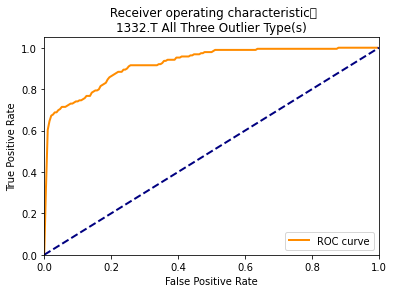

In [94]:
import itertools

def calc(l):
	lst = list(itertools.chain.from_iterable(l)) if isinstance(l[0], list) else l
	lst_ret = []
	for i, x in enumerate(lst):
		lst_ret.append(sum(w <= i for w in lst)/len(lst))
	lst_ret.insert(0,0)
	return lst_ret

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve",
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f" Receiver operating characteristic\r\n{inst[1]} {outlier_type} Outlier Type(s)")
plt.legend(loc="lower right")
plt.show()